# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [4]:
!bash download_data.sh

--2022-03-16 12:42:09--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Распознаётся ufldl.stanford.edu (ufldl.stanford.edu)… 171.64.68.10
Подключение к ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 182040794 (174M) [text/plain]
Сохранение в: «train_32x32.mat»

train_32x32.mat     100%[===================>] 173,61M  8,87MB/s    за 25s     

2022-03-16 12:42:35 (6,95 MB/s) - «train_32x32.mat» сохранён [182040794/182040794]

--2022-03-16 12:42:35--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Повторное использование соединения с ufldl.stanford.edu:80.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 64275384 (61M) [text/plain]
Сохранение в: «test_32x32.mat»

test_32x32.mat      100%[===================>]  61,30M  8,47MB/s    за 7,1s    

2022-03-16 12:42:42 (8,60 MB/s) - «test_32x32.mat» сохранён [64275384/64275384]

ЗАВЕРШЕНО --2022-03-16 12:42:42--
Общее время: 33s
Загруже

In [223]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [225]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

/var/folders/qx/5dmjvwj50ysf44p31147cjt40000gn/T/ipykernel_34072/2810386256.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
/var/folders/qx/5dmjvwj50ysf44p31147cjt40000gn/T/ipykernel_34072/2810386256.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_fla

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [226]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [227]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [228]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for L1_W
Gradient check passed!
Checking gradient for L1_B
Gradient check passed!
Checking gradient for L2_W
Gradient check passed!
Checking gradient for L2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [229]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for L1_W
Gradient check passed!
Checking gradient for L1_B
Gradient check passed!
Checking gradient for L2_W
Gradient check passed!
Checking gradient for L2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [230]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [231]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 27.828631, Train accuracy: 0.214889, val accuracy: 0.215000
Loss: 23.503394, Train accuracy: 0.249778, val accuracy: 0.253000
Loss: 19.884021, Train accuracy: 0.299889, val accuracy: 0.300000
Loss: 16.931150, Train accuracy: 0.344556, val accuracy: 0.339000
Loss: 14.385688, Train accuracy: 0.387333, val accuracy: 0.396000
Loss: 12.123939, Train accuracy: 0.424222, val accuracy: 0.426000
Loss: 10.716846, Train accuracy: 0.461444, val accuracy: 0.470000
Loss: 9.128000, Train accuracy: 0.485889, val accuracy: 0.486000
Loss: 7.969772, Train accuracy: 0.502556, val accuracy: 0.488000
Loss: 6.684177, Train accuracy: 0.531000, val accuracy: 0.516000
Loss: 6.131888, Train accuracy: 0.557222, val accuracy: 0.538000
Loss: 5.408971, Train accuracy: 0.566889, val accuracy: 0.548000
Loss: 4.803028, Train accuracy: 0.577000, val accuracy: 0.555000
Loss: 4.300332, Train accuracy: 0.583667, val accuracy: 0.562000
Loss: 3.925002, Train accuracy: 0.594889, val accuracy: 0.582000
Loss: 3.411706, Tr

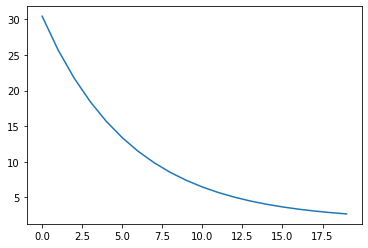

In [232]:
plt.plot(loss_history)

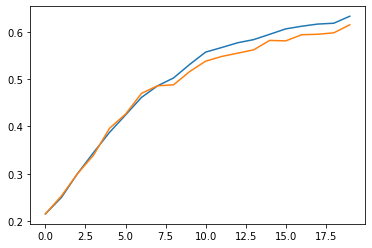

In [233]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [235]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 28.118159, Train accuracy: 0.232333, val accuracy: 0.237000
Loss: 23.601154, Train accuracy: 0.265333, val accuracy: 0.263000
Loss: 20.200291, Train accuracy: 0.318444, val accuracy: 0.311000
Loss: 16.964565, Train accuracy: 0.349889, val accuracy: 0.358000
Loss: 14.553134, Train accuracy: 0.399333, val accuracy: 0.403000
Loss: 12.903399, Train accuracy: 0.442556, val accuracy: 0.448000
Loss: 10.717856, Train accuracy: 0.463667, val accuracy: 0.467000
Loss: 9.471030, Train accuracy: 0.492333, val accuracy: 0.477000
Loss: 8.216975, Train accuracy: 0.512333, val accuracy: 0.502000
Loss: 7.320452, Train accuracy: 0.535111, val accuracy: 0.526000
Loss: 6.323233, Train accuracy: 0.553333, val accuracy: 0.542000
Loss: 5.737314, Train accuracy: 0.554111, val accuracy: 0.536000
Loss: 4.879599, Train accuracy: 0.565889, val accuracy: 0.547000
Loss: 4.484336, Train accuracy: 0.582111, val accuracy: 0.569000
Loss: 4.420973, Train accuracy: 0.586667, val accuracy: 0.572000
Loss: 3.928654, Tr

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [238]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-3, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 28.056102, Train accuracy: 0.230000, val accuracy: 0.226000
Loss: 23.735678, Train accuracy: 0.269333, val accuracy: 0.264000
Loss: 20.105021, Train accuracy: 0.300889, val accuracy: 0.294000
Loss: 17.000109, Train accuracy: 0.344778, val accuracy: 0.357000
Loss: 14.813773, Train accuracy: 0.397778, val accuracy: 0.392000
Loss: 12.652947, Train accuracy: 0.430889, val accuracy: 0.433000
Loss: 10.921232, Train accuracy: 0.459556, val accuracy: 0.471000
Loss: 9.545149, Train accuracy: 0.480667, val accuracy: 0.481000
Loss: 8.228750, Train accuracy: 0.500333, val accuracy: 0.505000
Loss: 7.171249, Train accuracy: 0.525889, val accuracy: 0.531000
Loss: 6.389941, Train accuracy: 0.549667, val accuracy: 0.548000
Loss: 5.966290, Train accuracy: 0.556111, val accuracy: 0.549000
Loss: 5.315978, Train accuracy: 0.572000, val accuracy: 0.566000
Loss: 4.835098, Train accuracy: 0.571000, val accuracy: 0.579000
Loss: 4.128659, Train accuracy: 0.581889, val accuracy: 0.580000
Loss: 3.746448, Tr

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [243]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 33.309892, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 32.488487, Train accuracy: 0.800000, val accuracy: 0.133333
Loss: 30.811116, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 30.473542, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 30.018279, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 29.448835, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 28.814563, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 28.407421, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 28.145741, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 27.869177, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 27.407869, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 26.964321, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 26.758952, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 26.291153, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 25.967601, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 25.7

Loss: 6.258720, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 6.160041, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 6.102342, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 6.023967, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 5.944387, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 5.878787, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 5.826493, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 5.748819, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 5.669222, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 5.620588, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 5.548896, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 5.486105, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 5.438803, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 5.368718, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 5.294955, Train accuracy: 1.000000, val accuracy: 0.000000


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [245]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 33.008283, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 31.924683, Train accuracy: 0.866667, val accuracy: 0.066667
Loss: 30.546440, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 30.064578, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 29.505054, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 29.511334, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 29.083928, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 28.380044, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 27.996059, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 27.585005, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 27.326736, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 26.913475, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 26.660170, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 26.281010, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 26.056145, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 25.6

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [264]:
# Let's train the best one-hidden-layer network we can

# learning_rates = 1e-4
# reg_strength = 1e-3
# learning_rate_decay = 0.999
# hidden_layer_size = 128
# num_epochs = 200
# batch_size = 64

learning_rates = [1e-2]
reg_strengths = [1e-3]
hidden_layer_sizes = [100, 150, 200]
num_epoches = [50,75]


best_classifier = None
best_val_accuracy = None

best_loss_history = []
best_train_history = []
best_val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

loss = 1e+10

for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        for hidden_layer_size in hidden_layer_sizes:
            for num_epoch in num_epoches:
                print(f'''learning_rate: {learning_rate}, reg_strength: {reg_strength}, 
                    hidden_layer_size: {hidden_layer_size}, num_epoch:{num_epoch}''')
                model = TwoLayerNet(train_X.shape[1], 10, hidden_layer_size, reg_strength)
                dataset = Dataset(train_X, train_y, val_X, val_y)
                trainer = Trainer(model, dataset, MomentumSGD(), num_epoch, 50, learning_rate)
                loss_history, train_history, val_history = trainer.fit()

                if loss > loss_history[-1]:
                    best_classifier = model
                    best_loss_history, best_train_history, best_val_history = loss_history, train_history, val_history  
                    loss = loss_history[-1]
                        
                    
                    
                    


print('best validation accuracy achieved: %f' % best_val_history[-1])

learning_rate: 0.01, reg_strength: 0.001, 
                    hidden_layer_size: 100, num_epoch:50
Loss: 5.141705, Train accuracy: 0.371333, val accuracy: 0.361000
Loss: 4.491518, Train accuracy: 0.542667, val accuracy: 0.524000
Loss: 4.003587, Train accuracy: 0.617667, val accuracy: 0.602000
Loss: 3.664275, Train accuracy: 0.653889, val accuracy: 0.628000
Loss: 3.419832, Train accuracy: 0.696333, val accuracy: 0.669000
Loss: 3.184877, Train accuracy: 0.712111, val accuracy: 0.690000
Loss: 2.997846, Train accuracy: 0.733000, val accuracy: 0.695000
Loss: 2.830382, Train accuracy: 0.730000, val accuracy: 0.710000
Loss: 2.674536, Train accuracy: 0.748111, val accuracy: 0.694000
Loss: 2.538066, Train accuracy: 0.763667, val accuracy: 0.714000
Loss: 2.410490, Train accuracy: 0.777667, val accuracy: 0.709000
Loss: 2.287710, Train accuracy: 0.788333, val accuracy: 0.727000
Loss: 2.184769, Train accuracy: 0.795333, val accuracy: 0.729000
Loss: 2.081597, Train accuracy: 0.806667, val accuracy:

Loss: 2.786356, Train accuracy: 0.792444, val accuracy: 0.708000
Loss: 2.643779, Train accuracy: 0.816889, val accuracy: 0.732000
Loss: 2.515561, Train accuracy: 0.800000, val accuracy: 0.716000
Loss: 2.388344, Train accuracy: 0.832444, val accuracy: 0.742000
Loss: 2.272860, Train accuracy: 0.795778, val accuracy: 0.703000
Loss: 2.171464, Train accuracy: 0.831444, val accuracy: 0.747000
Loss: 2.064413, Train accuracy: 0.842667, val accuracy: 0.732000
Loss: 1.972110, Train accuracy: 0.838556, val accuracy: 0.750000
Loss: 1.892233, Train accuracy: 0.842333, val accuracy: 0.753000
Loss: 1.810522, Train accuracy: 0.841667, val accuracy: 0.739000
Loss: 1.745602, Train accuracy: 0.856667, val accuracy: 0.767000
Loss: 1.668920, Train accuracy: 0.849222, val accuracy: 0.737000
Loss: 1.608092, Train accuracy: 0.867111, val accuracy: 0.748000
Loss: 1.551749, Train accuracy: 0.870222, val accuracy: 0.753000
Loss: 1.491111, Train accuracy: 0.852667, val accuracy: 0.741000
Loss: 1.450624, Train acc

Loss: 2.218755, Train accuracy: 0.860889, val accuracy: 0.746000
Loss: 2.118893, Train accuracy: 0.862111, val accuracy: 0.749000
Loss: 2.024965, Train accuracy: 0.865444, val accuracy: 0.747000
Loss: 1.941604, Train accuracy: 0.867556, val accuracy: 0.755000
Loss: 1.856789, Train accuracy: 0.870556, val accuracy: 0.757000
Loss: 1.773169, Train accuracy: 0.883000, val accuracy: 0.762000
Loss: 1.701354, Train accuracy: 0.881333, val accuracy: 0.759000
Loss: 1.639217, Train accuracy: 0.885444, val accuracy: 0.770000
Loss: 1.577721, Train accuracy: 0.884000, val accuracy: 0.773000
Loss: 1.521896, Train accuracy: 0.893444, val accuracy: 0.773000
Loss: 1.470204, Train accuracy: 0.890333, val accuracy: 0.768000
Loss: 1.414033, Train accuracy: 0.896444, val accuracy: 0.766000
Loss: 1.371054, Train accuracy: 0.894000, val accuracy: 0.763000
Loss: 1.329232, Train accuracy: 0.904333, val accuracy: 0.766000
Loss: 1.284585, Train accuracy: 0.895333, val accuracy: 0.765000
Loss: 1.269962, Train acc

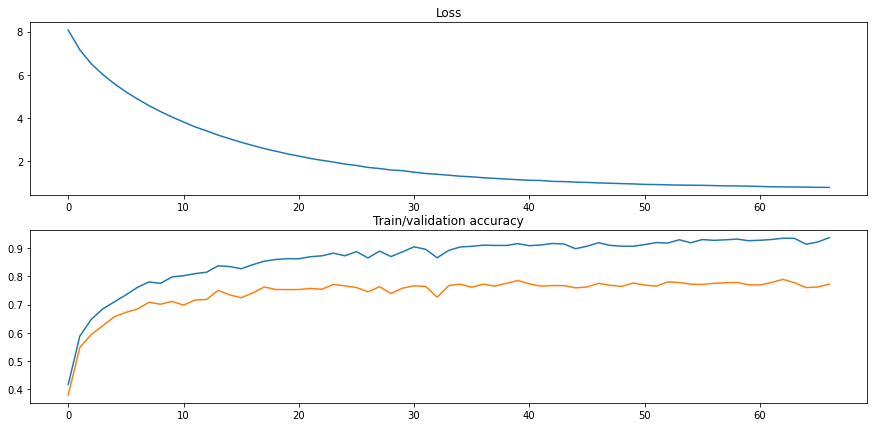

In [266]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

In [267]:
best_classifier = model

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [268]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.758000
